In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt, lfilter
from scipy.signal import find_peaks
from scipy import signal
from scipy.ndimage import convolve1d
from matplotlib import dates as mdate
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8') # Per rendere i plot più belli

### Giovanni Luongo (5038815)

# Diagnosi di patologie motorie attraverso l'analisi del cammino

# 1. Obiettivi

L'analisi del movimento è un passo fondamentale nella diagnosi di patologie motorie e nella riabilitazione. L'analisi può riguardare l'intero corpo o solo una parte. All'interno di questo progetto **analizzeremo il cammino concentrandoci su specifici punti anatomici legati all'individuazione del ciclo del passo** studiando segnali. 

I **dati** su cui lavoriamo sono ottenuti da **analisi video** di corpi in movimento e contengono informazioni posizionali sul piano immagine. Tali informazioni sono ottenute attraverso l'utilizzo di **sensori**, i quali sono **soggetti a frequenti errori di misurazione** che rendono le rilevazioni inattendibili. 

In particolare, utilizziamo un *dataset* contenente rilevazioni relative a **camminate normali** di **persone sane** (S) e di persone affette da **patologie motorie** (P). Per ogni soggetto analizzato, i dati sono contenuti all'interno di una **matrice** dove ogni riga rappresenta un istante di tempo e le colonne [x1, y1, c1, ... x25, y25, c25] contengono le posizioni pixel sul piano immagine per ogni punto anatomico, dove c è la **confidenza**, dato che ci rivela se la rilevazione associata è affidabile.

All'interno del notebook proveremo a:
- **Rendere utilizzabili i dati per le nostre analisi**, adottando tecniche per rimuovere le fonti di inaffidabilità. 
- **Identificare l'inizio e la fine di un ciclo del passo** basandosi su semplificazioni di nozioni sul movimento dei corpi.

Scopi del notebook (**obiettivi**):
- Capire se esistono dettagli nel modo in cui si cammina che possono **rivelare se questo è affetto da problemi motori a partire dal'analisi del ciclo del passo**.

Il notebook affronta il problema della diagnosi di patologie motorie avvalendosi di semplificazioni, le nostre analisi sul cammino infatti sono di tipo **qualitativo** e vogliono porre al centro la visualizzazione dei segnali, opportunamente filtrati, e l'analisi dei grafici. Le conclusioni a cui arriveremo vogliono essere soltanto un punto di partenza per analisi più approfondite.

# 2. Metodi

## 2.1. Filtraggio

I dati che analizziamo soffrono di **frequenti errori nelle rilevazioni** a causa di diversi fattori (occlusioni o altri fenomeni passeggeri). Nelle serie temporali questi eventi si traducono in **spike molto localizzati**. 

All'interno dei dati a nostra disposizione, gli errori sono principalmente dovuti a **occlusioni**. I sensori utilizzati per le rilevazioni infatti analizzano il movimento dei punti anatomici dal piano immagine e spesso **arti opposti si sovrappongono**, generando brevi ostruzioni.

Per **rendere i segnali utilizzabili** in vista di analisi successive, bisogna adottare **tecniche di filtraggio** con lo scopo di ripulire tutte quelle zone del segnale in cui c'è forte rumore (e che, come abbiamo già detto, corrispondono alle zone in cui ci sono stati problemi nelle rilevazioni, dove la confidenza è 0). Proveremo a fare questo in **3 fasi**:
1. Applichiamo un **filtro mediano** che pulisce il segnale dagli spike molto localizzati (i piccoli errori di sensore).
2. Il filtro mediano non basta, bisogna poi fare **interpolazione** delle zone problematiche più grandi.
3. Infine applichiamo un **filtro gaussiano** per ripulire ulteriormente il segnale ed eliminare le fluttuazioni, ottenendo un segnale più smussato.

### 2.1.1. Filtro mediano

Il **filtro mediano** è una tecnica di filtraggio utilizzata per ridurre il rumore nei segnali ed è **particolarmente efficace nel rimuovere spike molto localizzati**. Solitamente viene utilizzato come **pre-processing** prima di effettuare altre operazioni.

Il funzionamento si basa sullo **scorrimento di una finestra sui dati**. Vengono letti i valori compresi nella finestra e i valori originali all'interno di essa vengono sostuiti con il valore ottenuto calcolando la **mediana** di tali valori. In questo modo il filtro elimina gli spike causati da errori di sensore di breve durata. 

Utilizziamo la funzione di libreria **```signal.medfilt```**, la quale prende in input un array e un intero che definisce la dimensione della finestra.

In [2]:
# Funzione per ricavare dalla matrice dei dati la colonna di nostro interesse.
def getColumn(data, pt_anatomico):
    return data[0:data.shape[0], pt_anatomico]

In [3]:
def applyMedianFilter(dataColumn, kernelSize):
    return signal.medfilt(dataColumn, kernel_size = kernelSize)

Il filtro mediano **non modifica la struttura temporale** del segnale.

Aumentare la *kernel size* aumenta la dimensione della finestra e permette di ripulire zone di errore più grandi. Poiché nei nostri segnali sono presenti sia spike molto localizzati che zone di errore più grandi,  utilizzare il filtro mediano per ripulire l'intero segnale non è ideale, lo adottiamo solo per **rimuovere le brevi occlusioni**. 

### 2.1.2. Interpolazione

Utilizziamo la tecnica dell'**interpolazione** per **ripulire le zone di errore più grandi**. 

L'interpolazione è un processo mediante il quale **si stima il valore del segnale tra due punti noti**. Nel notebook, utilizziamo tale processo per rimuovere le **occlusioni prolungate**, sostituendole con **valori stimati a partire dai valori confinanti noti**, garantendo una **rappresentazione continua del segnale nel tempo**.

Per ottenere ciò, implementiamo una tecnica che prevede **due fasi**.

In primo luogo, **trasformiamo i valori contenuti nelle zone di errore (che equivalgono a 0) in NaN (Not a Number)**.

In [4]:
# Trasformiamo gli 0 in NaN.
def zeroToNaN(dataColumn):
    dataColumn[dataColumn==0] = np.nan

Successivamente, **interpoliamo le zone vuote** (che effettivamente contengono NaN) **a partire dai valori contenuti nelle zone confinanti**.

In [5]:
# Interpolazione sui NaN.
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

def interpNaN(dataColumn):
    nans, x = nan_helper(dataColumn)
    dataColumn[nans] = np.interp(x(nans), x(~nans), dataColumn[~nans])

Dopo aver applicato filtro mediano e interpolazione, abbiamo a nostra disposizione un **segnale con una quantità di rumore notevolmente ridotta**.

### 2.1.3. Filtro gaussiano

L'ultima tappa della pipeline di filtraggio adottata è l'applicazione del **filtro gaussiano** sui segnali preprocessati.

Il filtro **attenua le fluttuazioni indesiderate** e permette di ottenere un **segnale smussato e uniforme**. È particolarmente efficace nel ridurre il rumore a bassa frequenza. 

Per prima cosa, generiamo una **finestra di Gauss** con la funzione di libreria **```signal.windows.gaussian```** che prende in input un intero che rappresenta il numero di punti che saranno presenti nella finestra generata e un float per la deviazione standard.

In [6]:
windowg = signal.windows.gaussian(51, std=3)
windowg /= sum(windowg) 

In seguito, utilizziamo un'altra funzione di libreria, **```scipy.ndimage.convolve1d```**, che esegue la **convoluzione** 1D tra la sequenza di dati fornita e la finestra generata precedentemente.

In [7]:
def applyGaussianFilter(dataColumn, window):
    return convolve1d(dataColumn[0:dataColumn.shape[0]], window)

L'utilizzo combinato di queste tecniche di filtraggio rende i nostri **segnali uniformi e privi di disturbi**, pronti per analisi successive più approfondite.

In [8]:
# Funzione che prende in input la colonna dei dati di interesse e applica il filtraggio completo descritto precedentemente.
def applyCompleteFiltering(dataColumn):
    med_filt = applyMedianFilter(dataColumn, 7)
    zeroToNaN(med_filt)
    interpNaN(med_filt)
    complete_filt = applyGaussianFilter(med_filt, windowg)
    return complete_filt

## 2.2. Identificazione inizio e ciclo del passo

Il **cammino** è un fenomeno complesso che coinvolge molteplici punti anatomici. In condizioni normali, la sequenza di azioni svolte dagli arti inferiori viene effettuata in maniera **sequenziale e ripetitiva**, ripetendosi dopo un tempo definito e prevedendo sempre l'appoggio di almeno un arto sulla superficie terrestre. In condizioni anomale invece, questo non è necessariamente valido.

È difficile definire con precisione l'inizio e la fine di un ciclo del passo. Tuttavia, la **prima azione facile da individuare è il contatto iniziale**. In genere, questo viene identificato nell'**appoggio al suolo del tallone dell'arto preso in riferimento** (anche se questa cosa non è del tutto corretta, ci baseremo su questa semplificazione nelle nostre analisi). Per questo motivo le nostre analisi riguarderanno principalmente i punti anatomici del **tallone destro e sinistro**.

In [9]:
# Analizzeremo il ciclo del passo attraverso i seguenti punti anatomici:
# 1. Tallone destro
x_tallone_dx = 69
y_tallone_dx = 70
c_tallone_dx = 71

# 2. Tallone sinistro
x_tallone_sx = 60
y_tallone_sx = 61
c_tallone_sx = 62

Il **ciclo del passo** viene suddiviso in **due periodi**:

- **Appoggio** (stance): periodo durante il quale il piede preso in riferimento è in contatto con il terreno, ha inizio con il contatto iniziale e rappresenta la maggior parte del ciclo.
- **Oscillazione** (swing): periodo in cui il piede si trova sollevato per l'avanzamento dell'altro arto, il distacco del piede dal terreno ne segna l'inizio.

Ci sono momenti in cui entrambi gli arti si trovano in fase di appoggio. Durante il cammino, non si verificherà mai che entrambi gli arti siano sollevati dal terreno. In cammino, **un singolo arto poggia al suolo, mentre l'altro arto avanza in oscillazione**. I **talloni** opposti dunque, in condizioni normali, seguono un andamento speculare alternandosi, dove **mentre uno è in appoggio, l'altro è sollevato in oscillazione**.

Possiamo dunque dire che per identificare l'**inizio di un passo**, bisogna trovare il **momento in cui il tallone tocca il terreno**. Poiché i nostri dati sono ottenuti da rilevazioni immagine, l'origine delle y (ossia la parte più vicina al terreno) si trova in alto, quindi per fare questo ci basterà trovare i **punti di picco** (peaks) del segnale, che corrisponderanno ai momenti in cui il tallone tocca il terreno.

Per farlo utilizziamo la funzione di libreria **```scipy.signal.find_peaks```**, che prende in input la sequenza di dati, una soglia (threshold) e **trova i massimi locali** attraverso confronti con i valori circostanti. La funzione restituisce un array contenente gli indici dei picchi trovati nella sequenza fornita in input.

Possiamo dunque inquadrare un passo intero quindi **partendo da un picco e arrivando al picco successivo**. Possiamo inquadrare l'intera camminata rilevata dai sensori partendo dal primo picco e arrivando all'ultimo misurato, che corrisponde all'ultimo appoggio.

# 3. Esperimenti

## 3.1. Errori nelle rilevazioni

Visualizziamo come gli **errori nelle rilevazioni dovuti alle occlusioni** si manifestano all'interno dei segnali analizzando per lo stesso soggetto e per la stessa direzione di cammino i dati ottenuti dalle rilevazioni per il tallone destro e il tallone sinistro.

Ciò che dovrebbe verificarsi è che, analizzando la camminata verso destra, **il tallone destro si troverà in rilievo rispetto al sensore e dovrebbe presentare molte meno occlusioni rispetto al tallone opposto**, il quale verrà necessariamente occluso dalla sua controparte.

In [10]:
# Carichiamo i dati.
S005_R_data = np.loadtxt('data/N_S/S005_R_N_0.csv', delimiter=',')

# Estraiamo le colonne contenenti le rilevazioni relative al tallone destro.
S005_colonna_x_talldx_R = getColumn(S005_R_data, x_tallone_dx)
S005_colonna_y_talldx_R = getColumn(S005_R_data, y_tallone_dx)
S005_colonna_c_talldx_R = getColumn(S005_R_data, c_tallone_dx)

# Estraiamo le colonne contenenti le rilevazioni relative al tallone sinistro.
S005_colonna_x_tallsx_R = getColumn(S005_R_data, x_tallone_sx)
S005_colonna_y_tallsx_R = getColumn(S005_R_data, y_tallone_sx)
S005_colonna_c_tallsx_R = getColumn(S005_R_data, c_tallone_sx)

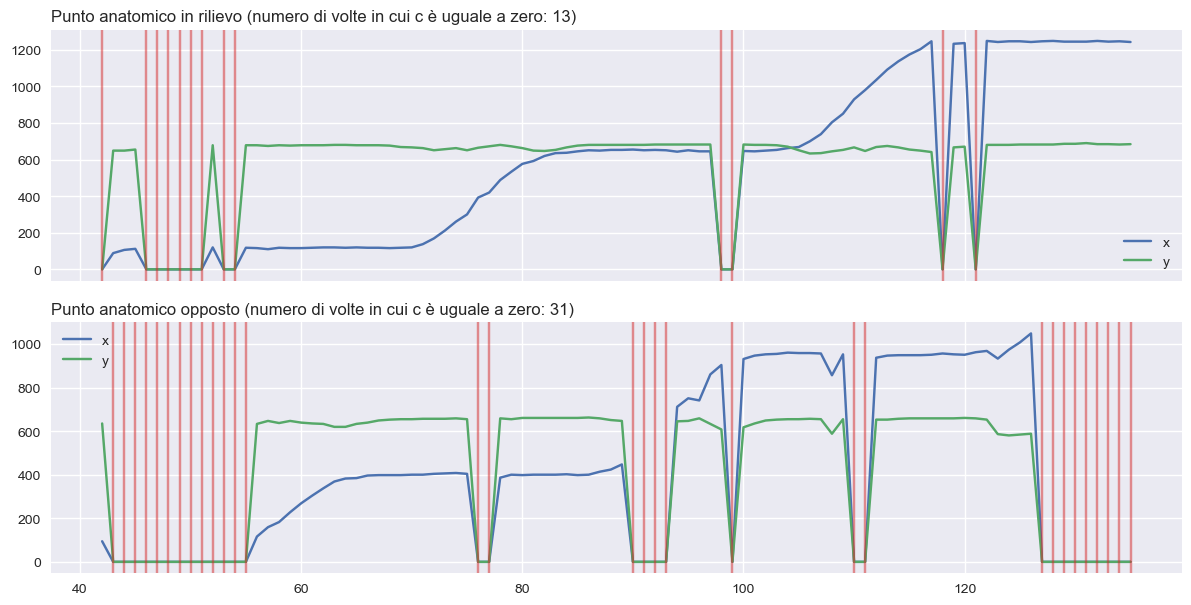

In [11]:
# Visualizziamo le zone con rumore.
fig, axs = plt.subplots(2, figsize=(12, 6))
fig.tight_layout()

# Punto anatomico in rilievo
axs[0].plot(S005_colonna_x_talldx_R, label='x')
axs[0].plot(S005_colonna_y_talldx_R, label='y')

# Evidenziamo le zone in cui la confidenza è 0 (zone errori di rilevazione).
indices = np.where(S005_colonna_c_talldx_R == 0)[0]
for index in indices: axs[0].axvline(x=index,color='tab:red', alpha=0.5)

axs[0].set_title(label="Punto anatomico in rilievo (numero di volte in cui c è uguale a zero: "+str(indices.size)+')', 
                 loc='left')
axs[0].legend()

# Punto anatomico opposto (coperto spesso dal punto precedente)
axs[1].plot(S005_colonna_x_tallsx_R, label='x')
axs[1].plot(S005_colonna_y_tallsx_R, label='y')
indices = np.where(S005_colonna_c_tallsx_R == 0)[0]
for index in indices: axs[1].axvline(x=index,color='tab:red', alpha=0.5)
axs[1].set_title(label="Punto anatomico opposto (numero di volte in cui c è uguale a zero: "+str(indices.size)+')', 
                 loc='left')
axs[1].legend()

for ax in fig.get_axes():
    ax.label_outer()

Possiamo notare che se analizziamo il movimento del tallone destro mentre il soggetto cammina verso destra, dunque con il punto anatomico in rilievo (non subisce occlusioni), gli 0 occasionali sono poco frequenti e quando appaiono sono localizzati a inizio e fine del segnale, momenti in cui il sensore è più soggetto a  errori poiché l'individuo in analisi entra ed esce dal campo visivo del sensore.

Come conferma di quanto sopra possiamo anche consultare il dato della **confidenza**, il quale è uguale a 0 meno volte rispetto a quanto vedremo in seguito poiché la rilevazione è soggetta a pochi errori.

Se invece analizziamo il tallone sinistro, che subisce occlusioni poiché dal lato opposto del corpo, possiamo notare che gli 0 occasionali sono molto piu frequenti, dato che il sensore ha problemi nel cogliere informazioni posizionali molto più spesso. Dunque possiamo anche notare che gli spike occasionali oltre ad essere a inizio e fine come prima, si trovano molto più frequentemente anche in mezzo al segnale.

Possiamo ancora una volta utilizzare la confidenza come conferma, la quale è 0 molte piu volte di prima.

## 3.2. Filtraggio del segnale

Proviamo a migliorare il segnale più rumoroso, ossia quello associato al movimento del **tallone sinistro** visto da destra, che subisce frequenti occlusioni dal tallone opposto.

### 3.2.1. Filtro mediano

Utilizziamo il filtro mediano per rimuovere le **brevi occlusioni**, che si manifestano all'interno del segnale nei brevi **spike** di 0.

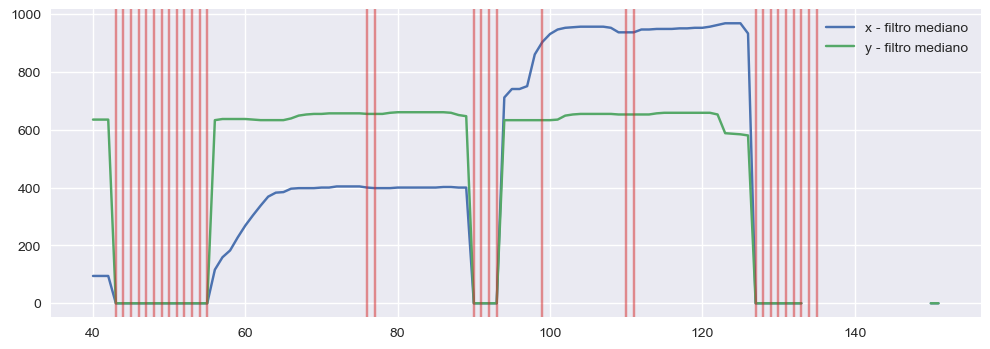

In [12]:
# Applichiamo il filtro mediano. Scegliamo 7 come size del kernel poiché 3 e 5 non bastano.
S005_filt_med_x_tallsx_R = applyMedianFilter(S005_colonna_x_tallsx_R, 7)
S005_filt_med_y_tallsx_R = applyMedianFilter(S005_colonna_y_tallsx_R, 7)

plt.figure(figsize=(12, 4))
plt.plot(S005_filt_med_x_tallsx_R, label='x - filtro mediano')
plt.plot(S005_filt_med_y_tallsx_R, label='y - filtro mediano')
plt.legend()

# Visualizziamo ancora le zone in cui la confidenza è 0 per vedere quali sono state ripulite.
indices = np.where(S005_colonna_c_tallsx_R == 0)[0]
for index in indices:
    plt.axvline(x=index,color='tab:red', alpha=0.5)

Il filtro mediano rimuove con successo le zone di errore molto piccole come previsto.

### 3.2.2. Interpolazione

Il filtro mediano non rimuove tutte le zone di errore, per rimuovere le zone più durature utilizziamo l'interpolazione.

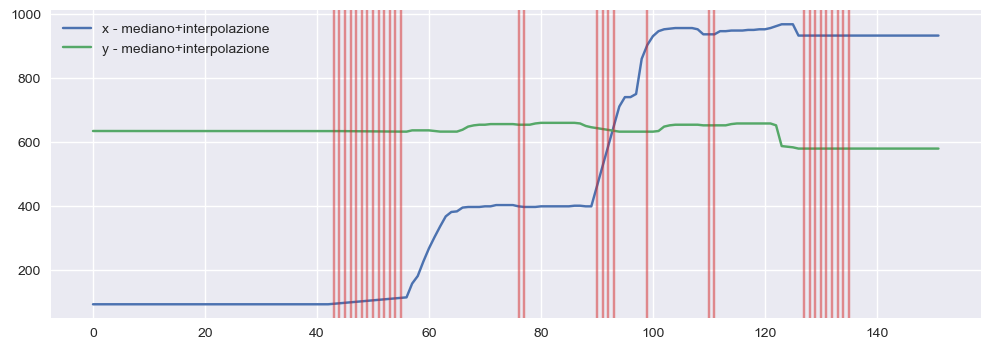

In [13]:
# Trasformiamo gli 0 in NaN
zeroToNaN(S005_filt_med_x_tallsx_R)
zeroToNaN(S005_filt_med_y_tallsx_R)

# Interpolazione dei NaN sull'asse delle x
interpNaN(S005_filt_med_x_tallsx_R)

# Interpolazione dei NaN sull'asse delle y
interpNaN(S005_filt_med_y_tallsx_R)

# Plot del segnale ripulito
plt.figure(figsize=(12, 4))
plt.plot(S005_filt_med_x_tallsx_R, label='x - mediano+interpolazione')
plt.plot(S005_filt_med_y_tallsx_R, label='y - mediano+interpolazione')
plt.legend()

# ed evidenziamo come le zone in cui la confidenza è 0 siano ora ripulite tutte.
indices = np.where(S005_colonna_c_tallsx_R == 0)[0]
for index in indices:
    plt.axvline(x=index,color='tab:red', alpha=0.5)

Attraverso l'utilizzo dell'interpolazione abbiamo ripulito il segnale sia dalle zone di errore brevi che quelle più lunghe.

### 3.2.3. Filtro gaussiano

Adesso che abbiamo rimosso le zone di errore dal segnale, possiamo migliorarlo ulteriormente applicando un filtro gaussiano, così da ottenere un segnale uniforme e con rumore ridotto.

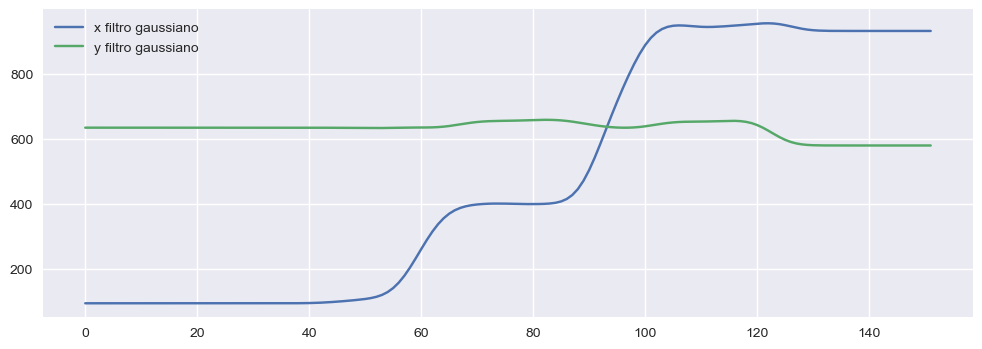

In [14]:
S005_gauss_filt_x_tallsx_R = applyGaussianFilter(S005_filt_med_x_tallsx_R, windowg)
S005_gauss_filt_y_tallsx_R = applyGaussianFilter(S005_filt_med_y_tallsx_R, windowg)

plt.figure(figsize=(12,4))
plt.plot(S005_gauss_filt_x_tallsx_R, label='x filtro gaussiano')
plt.plot(S005_gauss_filt_y_tallsx_R, label='y filtro gaussiano')
plt.legend()

### 3.2.4. Visualizzazione pipeline di filtraggio

Riassumiamo l'intero processo di filtraggio utilizzato all'interno del notebook prendendo in esame il filtraggio delle **y per il tallone sinistro**.

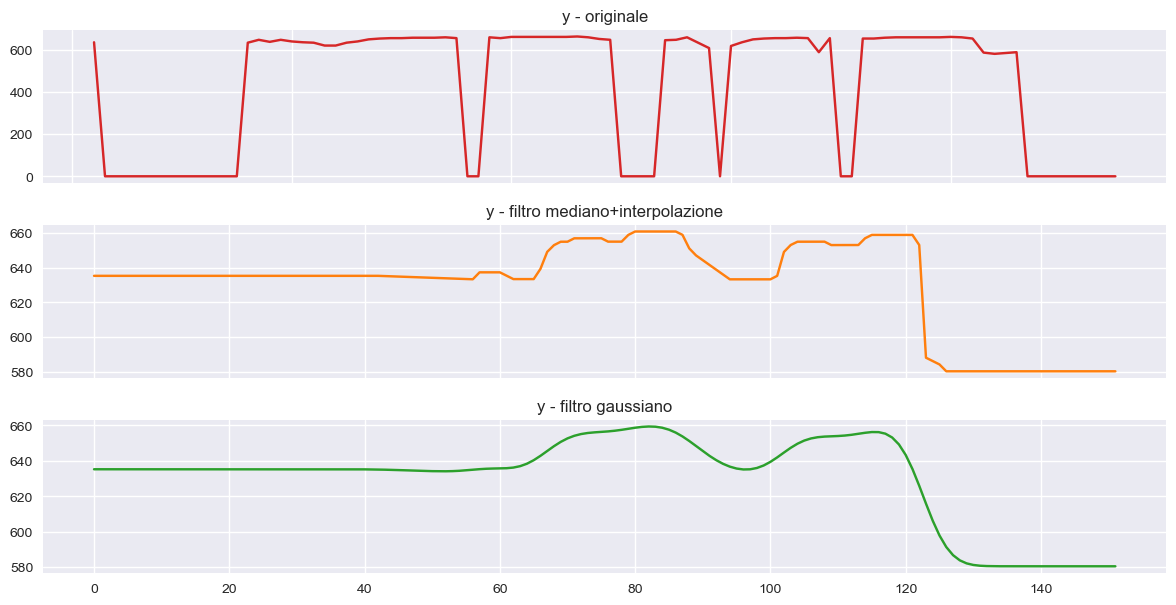

In [15]:
fig, axs = plt.subplots(3, figsize=(12, 6))
fig.tight_layout()
axs[0].plot(S005_colonna_y_tallsx_R, 'tab:red')
axs[0].set_title("y - originale")

axs[1].plot(S005_filt_med_y_tallsx_R, 'tab:orange')
axs[1].set_title("y - filtro mediano+interpolazione")

axs[2].plot(S005_gauss_filt_y_tallsx_R, 'tab:green')
axs[2].set_title("y - filtro gaussiano")

for ax in fig.get_axes():
    ax.label_outer()

## 3.3. Identificazione del passo

Per identificare l'**inizio di un passo**, bisogna trovare il **momento in cui il tallone tocca il terreno**. Per farlo, dobbiamo trovare i punti di picco del segnale, ossia i punti in cui il tallone tocca il terreno.

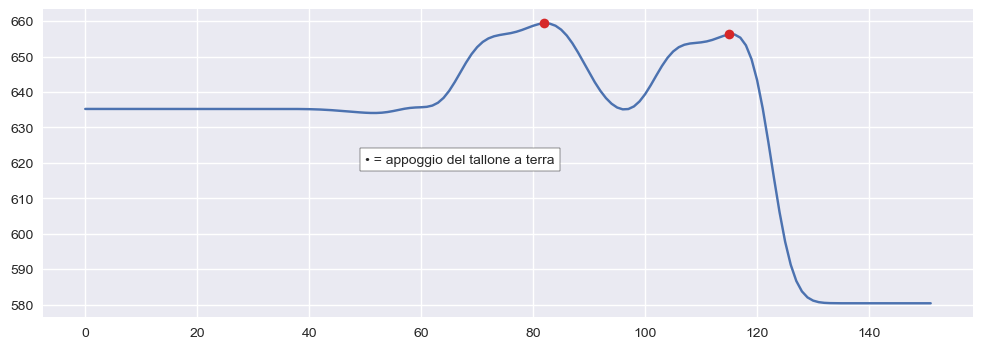

In [16]:
# NB: Poiché i dati posizionali sono ottenuti da immagini, le y vanno pensate al contrario:
# valori alti di y corrispondono a altezze inferiori nella realtà e viceversa.

peaks, _ = find_peaks(S005_gauss_filt_y_tallsx_R, height=0)

plt.figure(figsize=(12, 4))
plt.plot(S005_gauss_filt_y_tallsx_R, label='y')
plt.plot(peaks, S005_gauss_filt_y_tallsx_R[peaks], "o", color='tab:red')

plt.text(50, 620, '• = appoggio del tallone a terra',
         bbox={'facecolor': 'white'})
plt.show()

Come conferma del fatto che il passo appena individuato sia corretto, vediamo ciò che succede nel tallone opposto durante gli stessi istanti di tempo. Ciò che dovrebbe verificarsi è che, **mentre il tallone sinistro è in oscillazione, il tallone destro sia in appoggio**.

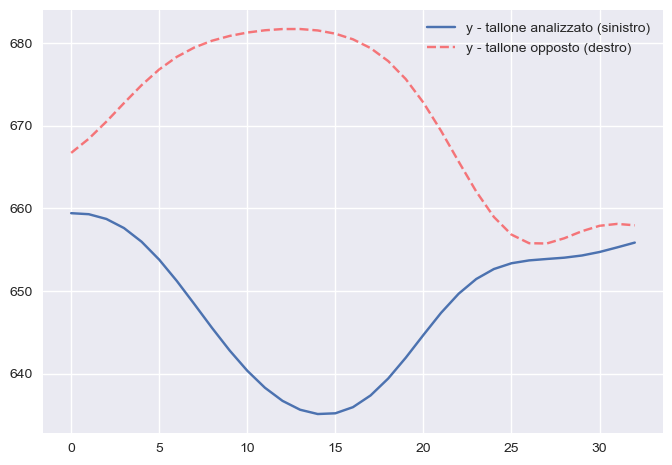

In [17]:
# Per verificare che il ciclo del passo inviduato sia corretto, puliamo anche il segnale del tallone opposto e vediamo
# se rispetta le nostre conoscenze di teoria (ossia: quando uno è alzato, l'altro è in appoggio).
S005_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(S005_R_data, y_tallone_dx))

peaks, _ = find_peaks(S005_gauss_filt_y_tallsx_R, height=0)
plt.plot(S005_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
plt.plot(S005_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
plt.legend()

Come possiamo notare, i segnali per il movimento dei talloni opposti sono pressappoco speculari, come previsto, poiché mentre uno è in appoggio, l'altro dovrebbe essere in oscillazione e viceversa.

## 3.4. Visualizzazione del passo dei soggetti sani a confronto

Applichiamo le stesse tecniche utilizzate negli esperimenti precedenti a **tutti i soggetti sani** e vediamo i grafici a confronto per cominciare a fare **osservazioni** di tipo qualitativo sui risultati.

In [18]:
S008_R_data = np.loadtxt('data/N_S/S008_R_N_0.csv', delimiter=',')
S008_gauss_filt_y_tallsx_R = applyCompleteFiltering(getColumn(S008_R_data, y_tallone_sx))
S008_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(S008_R_data, y_tallone_dx))

S012_R_data = np.loadtxt('data/N_S/S012_R_N_0.csv', delimiter=',')
S012_gauss_filt_y_tallsx_R = applyCompleteFiltering(getColumn(S012_R_data, y_tallone_sx))
S012_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(S012_R_data, y_tallone_dx))

S016_R_data = np.loadtxt('data/N_S/S016_R_N_0.csv', delimiter=',')
S016_gauss_filt_y_tallsx_R = applyCompleteFiltering(getColumn(S016_R_data, y_tallone_sx))
S016_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(S016_R_data, y_tallone_dx))

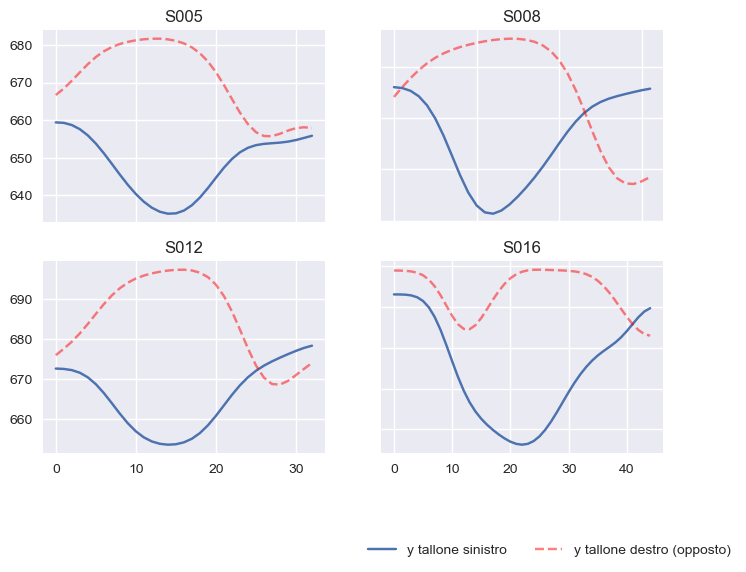

In [19]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(S005_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[0, 0].plot(S005_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[0, 0].set_title('S005')

peaks, _ = find_peaks(S008_gauss_filt_y_tallsx_R, height=0)
axs[0, 1].plot(S008_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[0, 1].plot(S008_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[0, 1].set_title('S008')

peaks, _ = find_peaks(S016_gauss_filt_y_tallsx_R, height=0)
axs[1, 1].plot(S016_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[1, 1].plot(S016_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[1, 1].set_title('S016')

peaks, _ = find_peaks(S012_gauss_filt_y_tallsx_R, height=0)
axs[1, 0].plot(S012_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[1, 0].plot(S012_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[1, 0].set_title('S012')

fig.legend(['y tallone sinistro', 'y tallone destro (opposto)'], loc='lower right', 
           bbox_to_anchor=(1,-0.1), ncol=2, bbox_transform=fig.transFigure)

for ax in axs.flat:
    ax.label_outer()

Possiamo notare che, utilizzando le tecniche adottate precedente nel notebook, in tutti i soggetti il passo viene riconosciuto correttamente poiché, mentre un tallone è in oscillazione, l'altro è in appoggio.

Possiamo inoltre notare che il passo delle persone sane è affine per tutti i soggetti e, all'interno del passo, la distanza tra il minimo di un tallone e il massimo del tallone opposto è piuttosto simile per tutte le persone analizzate.

## 3.5. Visualizzazione del passo dei soggetti malati a confronto

Adottiamo le stesse tecniche dell'esperimento precedente ma per i soggetti malati e vediamo se il cammino dei malati presenta **differenze** rispetto a quello dei sani.

In [20]:
P002_R_data = np.loadtxt('data/N_P/P002_R_N_0.csv', delimiter=',')
P002_gauss_filt_y_tallsx_R = applyCompleteFiltering(getColumn(P002_R_data, y_tallone_sx))
P002_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(P002_R_data, y_tallone_dx))

P006_R_data = np.loadtxt('data/N_P/P006_R_N_0.csv', delimiter=',')
P006_gauss_filt_y_tallsx_R = applyCompleteFiltering(getColumn(P006_R_data, y_tallone_sx))
P006_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(P006_R_data, y_tallone_dx))

P011_R_data = np.loadtxt('data/N_P/P011_R_N_0.csv', delimiter=',')
P011_gauss_filt_y_tallsx_R = applyCompleteFiltering(getColumn(P011_R_data, y_tallone_sx))
P011_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(P011_R_data, y_tallone_dx))

P025_R_data = np.loadtxt('data/N_P/P025_R_N_0.csv', delimiter=',')
P025_gauss_filt_y_tallsx_R = applyCompleteFiltering(getColumn(P025_R_data, y_tallone_sx))
P025_gauss_filt_y_talldx_R = applyCompleteFiltering(getColumn(P025_R_data, y_tallone_dx))

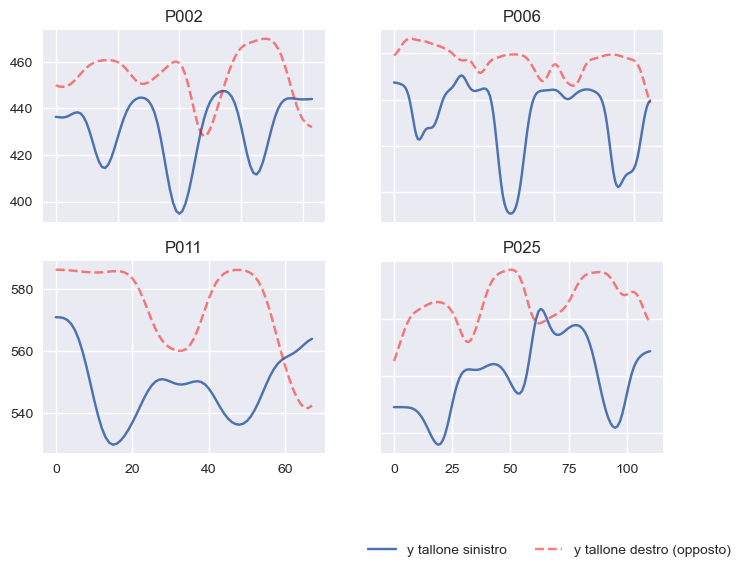

In [21]:
fig, axs = plt.subplots(2, 2)

peaks, _ = find_peaks(P002_gauss_filt_y_tallsx_R, height=0)
axs[0, 0].plot(P002_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[0, 0].plot(P002_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[0, 0].set_title('P002')
#sizeP002 = np.size(P002_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]])

peaks, _ = find_peaks(P006_gauss_filt_y_tallsx_R, height=0)
axs[0, 1].plot(P006_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[0, 1].plot(P006_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[0, 1].set_title('P006')
#sizeP006 = np.size(P006_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]])

peaks, _ = find_peaks(P011_gauss_filt_y_tallsx_R, height=0)
axs[1, 0].plot(P011_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[1, 0].plot(P011_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[1, 0].set_title('P011')
#sizeP011 = np.size(P011_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]])

peaks, _ = find_peaks(P025_gauss_filt_y_tallsx_R, height=0)
axs[1, 1].plot(P025_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]], label='y - tallone analizzato (sinistro)')
axs[1, 1].plot(P025_gauss_filt_y_talldx_R[peaks[0]:peaks[-1]], label='y - tallone opposto (destro)', 
         color='r', linestyle='--', alpha=0.5)
axs[1, 1].set_title('P025')
#sizeP025 = np.size(P025_gauss_filt_y_tallsx_R[peaks[0]:peaks[-1]])

fig.legend(['y tallone sinistro', 'y tallone destro (opposto)'], loc='lower right', 
           bbox_to_anchor=(1,-0.1), ncol=2, bbox_transform=fig.transFigure)

for ax in axs.flat:
    ax.label_outer()

Possiamo notare che con i **soggetti malati il cammino risulta essere molto diverso rispetto a prima**. È molto più difficile nel cammino identificare un **pattern** che si ripete; il passo infatti risulta meno prevedibile e, se nei soggetti sani il passo era pressocchè analogo per tutti i soggetti, la stessa cosa non vale qui.

# 4. Conclusioni

Osservazioni sui **metodi**:
- Le tecniche di **filtraggio** adottate hanno reso utilizzabili anche i segnali più rumorosi, permettendoci di individuare l'inizio e il ciclo del passo correttamente in tutti i soggetti presi in analisi (come confermato dagli esperimenti 3.3, 3.4, 3.5).

Osservazioni **qualitative sui grafici**: 
- Per quanto riguarda i soggetti **sani**, il cammino risulta simmetrico, periodico e l'oscillazione del passo raggiunge circa la stessa altezza per entrambi gli arti.
- Nei soggetti **malati** invece il passo risulta essere meno prevedibile, con frequenti fluttuazioni anche all'interno di uno stesso passo. Inoltre, i talloni dei malati in oscillazione raggiungono altezze sempre diverse e imprevedibili.

Possiamo quindi sicuramente affermare che **esistono dettagli nel modo in cui camminiamo che ci permettono di capire se un soggetto sia affetto da una patologia motoria o meno** e, grazie ai nostri esperimenti, possiamo dire che questi dettagli sono da ricercare nella **periodicità e simmetria del passo**.